In [10]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import json
from dateutil.parser import parse
import re
import matplotlib.pyplot as plt
import matplotlib
from xgboost import plot_importance
import requests
from sklearn.cross_validation import StratifiedKFold
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import confusion_matrix
import time
import datetime
from datetime import date
from bayes_opt import BayesianOptimization
from sklearn.cross_validation import cross_val_score
import numpy as np
import pytz
from sklearn.tree import DecisionTreeClassifier
import xml.etree.ElementTree as ET
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import itertools
from sklearn.learning_curve import learning_curve
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, LinearRegression, LassoCV
from sklearn.model_selection import GridSearchCV
from collections import Counter
from sklearn.metrics import mean_absolute_error
import scipy.stats as stats
import pylab as pl
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras.constraints import maxnorm
from keras.layers import Dropout
from sklearn import preprocessing
from keras.optimizers import SGD

In [8]:
# {"querytype":"occupancy","querytime":"2016-07-27T20:05:51+02:00",
# "post":{"connection":"http://irail.be/connections/8813003/20160727/IC1518",
# "from":"http://irail.be/stations/NMBS/008813003",
# "date":"Sun Jan 18 1970 01:14:03 GMT+0100 (CET)",
# "vehicle":"http://irail.be/vehicle/IC1518",
# "occupancy":"http://api.irail.be/terms/high"},
# "user_agent":"Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 
# (KHTML, like Gecko) Chrome/52.0.2743.82 Safari/537.36"}
_columns = ['querytime', 'seconds_since_midnight', 'hour', 'weekday', 'month', 'connection', 
            'from', 'from_string', 'from_lat', 'from_lng', 'morning_jam', 'evening_jam',
            'to', 'to_string', 'to_lat', 'to_lng', 'vehicle', 'vehicle_type', 'occupancy',
            'year', 'day', 'quarter', 'user-agent']

stations_df = pd.read_csv('stations.csv')
stations_df = stations_df[['URI','name', 'latitude', 'longitude']]
stations_df['URI'] = stations_df['URI'].apply(lambda x: x.split('/')[-1])
week_day_mapping = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}

def parse_file(path):
    parsed_logs = []
    faulty_logs = 0
    time_zones = []
    with open(path) as data_file:  
        for line in data_file:
            occ_logline = json.loads(line)
            morning_commute = 0
            evening_commute = 0
            commute_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
            # Do a check if the querytype is occupancy
            if occ_logline['querytype'] == 'occupancy' and 'error' not in occ_logline \
            and 'querytime' in occ_logline:

                    try:
                        query_time = occ_logline['querytime']
                        try:
                            parsed_query_time = parse(query_time)
                            week_day = week_day_mapping[parsed_query_time.weekday()]
                            weekday_nr = parsed_query_time.weekday()
                            midnight = parsed_query_time.replace(hour=0, minute=0, second=0, microsecond=0)
                            seconds_since_midnight = (parsed_query_time - midnight).seconds
                            day = parsed_query_time.day
                            year = parsed_query_time.year
                            month = parsed_query_time.month
                            hour = parsed_query_time.hour
                            quarter = int(parsed_query_time.minute/15)
                            timezone_offset = parsed_query_time.tzinfo._offset
                            time_zones.append(timezone_offset)
                            hours_offset, remainder = divmod(timezone_offset.seconds, 3600)
                            # De ochtendspits valt doorgaans in de periode van 7.00 tot 9.00 uur. 
                            # De avondspits valt in de regel tussen 16.30 en 18.30 uur.
                            if 6 < (hour - hours_offset + 1) < 10 and week_day in commute_days:
                                morning_commute = 1
                            if 15 < (hour - hours_offset + 1) < 19 and week_day in commute_days:
                                evening_commute = 1
                        except ValueError:
                            faulty_logs += 1
                            continue

                        from_id = occ_logline['post']['from'].split('/')[-1]
                        to_id = occ_logline['post']['to'].split('/')[-1]
                        vehicle_id = occ_logline['post']['vehicle'].split('/')[-1]
                        occupancy = occ_logline['post']['occupancy'].split('/')[-1]
                        connection = occ_logline['post']['connection']
                        from_string = stations_df[stations_df['URI'] == from_id]['name'].values[0]
                        to_string = stations_df[stations_df['URI'] == to_id]['name'].values[0]
                        from_lat = stations_df[stations_df['URI'] == from_id]['latitude'].values[0]
                        from_lng = stations_df[stations_df['URI'] == from_id]['longitude'].values[0]
                        to_lat = stations_df[stations_df['URI'] == to_id]['latitude'].values[0]
                        to_lng = stations_df[stations_df['URI'] == to_id]['longitude'].values[0]
                        user_agent = occ_logline['user_agent']
                        
                        if from_id[:2] == '00' and to_id[:2] == '00' and vehicle_id != 'undefined' \
                        and len(to_id) > 2 and len(from_id) > 2:
                            pattern = re.compile("^([A-Z]+)[0-9]+$")
                            vehicle_type = pattern.match(vehicle_id).group(1)
                            parsed_logs.append([parsed_query_time, seconds_since_midnight, hour, week_day, month,
                                                connection, from_id, from_string, from_lat, from_lng, morning_commute,
                                                evening_commute, to_id, to_string, to_lat, to_lng, vehicle_id, 
                                                vehicle_type, occupancy, year, day, quarter, user_agent])
                        else:
                            faulty_logs += 1
                    except Exception as e:
                        faulty_logs += 1
                        continue
        return parsed_logs, faulty_logs
                    
parsed_file1, faulty1 = parse_file('occupancy-2016-10-10.newlinedelimitedjsonobjects.jsonstream')
parsed_file2, faulty2  = parse_file('occupancy-until-20161029.newlinedelimitedjsonobjects')
parsed_file3, faulty3  = parse_file('occupancy-until-20161219.nldjson')
logs_df = pd.DataFrame(parsed_file1+parsed_file2+parsed_file3)
logs_df.columns = _columns
old_length = len(logs_df)
print(faulty1+faulty2+faulty3, 'logs discarded ---', old_length, 'parsed')
logs_df = logs_df.drop_duplicates(subset=['querytime', 'from', 'to', 'vehicle'])
print(old_length - len(logs_df), 'real duplicates removed')

329 logs discarded --- 4964 parsed
1402 real duplicates removed


### For each (vehicle, day, month, year) record, how many records do we have with lower querytime??

In [126]:
# For each record, get start and end station (from distance_df)
# Inter/extrapolate the occupancy over the whole line (WITH AND WITHOUT THIS STEP!!!)
# Get average score for (from_station, final_destination, hour) and add it as a feature
distance_df = pd.read_csv('distance_df.csv')
stations_df = pd.read_csv('stations.csv')
stations_df = stations_df[['URI','name', 'latitude', 'longitude']]
stations_df['URI'] = stations_df['URI'].apply(lambda x: x.split('/')[-1])
stations = list(stations_df['URI'].values)
new_feature_vectors = []
for i in range(len(distance_df)):
    entry = distance_df.iloc[i,:]
    max_value = -1
    end_station = None
    for station in stations:
        if entry[station] > max_value:
            max_value = entry[station]
            end_station = station
    new_feature_vectors.append(list(entry.values) + [end_station])
distance_df_end = pd.DataFrame(new_feature_vectors)
distance_df_end.columns = list(distance_df.columns) + ['end_station']
distance_df_end.to_csv('distance_df.csv')

In [ ]:
for i in range(len(logs_df)):
    entry = logs_df.iloc[i,:]
    filtered_df = logs_df[(logs_df['vehicle'] == entry['vehicle']) &
                          (logs_df['day'] == entry['day']) &
                          (logs_df['month'] == entry['month']) &
                          (logs_df['year'] == entry['year']) &
                          (logs_df['querytime'] < entry['querytime'])]
    if len(filtered_df) > 0:
        print(entry['vehicle'], entry['day'], entry['month'], len(filtered_df), 
              [abs(entry['querytime'] - x).total_seconds() for x in filtered_df['querytime'].values], 
              list(filtered_df['clf_occupancy'].values), list(filtered_df['from_string'].values),
              list(filtered_df['user-agent'].values))
# For each record, get start and end station (from distance_df)

# Inter/extrapolate the occupancy over the whole line (WITH AND WITHOUT THIS STEP!!!)

# Recalculate average_score

# Do evaluation if you take the occupancies of 5 previous station (default: low) in account

In [136]:
distance_df = pd.read_csv('distance_df.csv')
print(sum(distance_df['end_station'].isnull()))
new_feature_vectors = []
for i in range(len(distance_df)):
    entry = distance_df.iloc[i,:]
    filtered_occs = list(distance_df[(distance_df['hour'] == entry['hour'])
                                  & (distance_df['from_string'] == entry['from_string'])
                                  & (distance_df['end_station'] == entry['end_station'])
                                  & (distance_df['vehicle_type'] == entry['vehicle_type'])]['occupancy'].values)
    filtered_occs.remove(entry['occupancy'])
    if len(filtered_occs) > 0:
        mean_occupancy = np.mean([{'low': 1, 'medium': 3, 'high': 5}[x] for x in filtered_occs])
    else:
        mean_occupancy = 0.0
    
    new_feature_vectors.append(list(entry.values) + [mean_occupancy])
distance_df_end = pd.DataFrame(new_feature_vectors)
distance_df_end.columns = list(distance_df.columns) + ['avg_hour_score']
distance_df_end.to_csv('distance_score_df.csv')

0


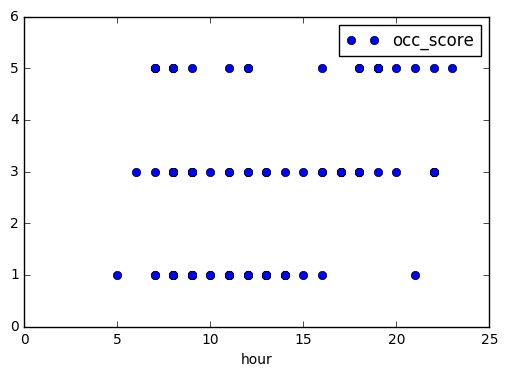

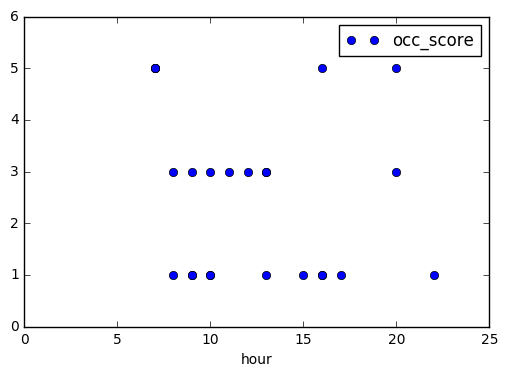

In [109]:
# Plot the distribution of occupancies for connection Gent --> Brussel-Zuid
distance_df = pd.read_csv('distance_df.csv')
#print(len(distance_df))
#distance_df = distance_df[(distance_df['from_string'] == 'Brugge')
#                          & (-pd.isnull(distance_df['008892007']))]
distance_df['occ_score'] = distance_df['occupancy'].map({'low': 1, 'medium': 3, 'high': 5})

distance_df[(distance_df['from_string'] == 'Brugge')
             & (-pd.isnull(distance_df['008892007']))].plot(x='hour', y='occ_score', style='o',
                                                             xlim=(0, 25),
                                                             ylim=(0, 6))

distance_df[(distance_df['from_string'] == 'Aalter')
             & (-pd.isnull(distance_df['008892007']))].plot(x='hour', y='occ_score', style='o',
                                                             xlim=(0, 25),
                                                             ylim=(0, 6))

In [45]:
unique_combos = list(set([tuple(x) for x in weather_delay_features[['vehicle', 'day', 'month', 'hour']].to_records(index=False)]))
print(len(unique_combos))

2685


In [66]:
railer_logs = 0
new_vectors = []
for i in range(len(logs_df)):
    entry = logs_df.iloc[i,:]
    last_occ = np.NaN
    if 'Railer' in entry['user-agent']: railer_logs += 1
    filtered_df = logs_df[(logs_df['vehicle'] == entry['vehicle']) &
                          (logs_df['day'] == entry['day']) &
                          (logs_df['month'] == entry['month']) &
                          (logs_df['year'] == entry['year']) &
                          (logs_df['dep_sec_since_midnight'] < entry['dep_sec_since_midnight'])]
    #if len(filtered_df) > 0:
    #    print(entry['vehicle'], entry['day'], entry['month'], len(filtered_df), 
    #          [abs(parse(entry['querytime']) - parse(x)).total_seconds() for x in filtered_df['querytime'].values], 
    #          list(filtered_df['clf_occupancy'].values), list(filtered_df['from_string'].values),
    #          list(filtered_df['user-agent'].values))
    if len(filtered_df) > 0:    
        filtered_df = filtered_df.sort_values(by='dep_sec_since_midnight', ascending=False)
        latest_entry = filtered_df.iloc[0,:]
        time_diff = abs(parse(entry['querytime']) - parse(latest_entry['querytime'])).total_seconds()
        if time_diff < 1000:
            last_occ = latest_entry['clf_occupancy']

    new_vectors.append(list(entry.values) + [last_occ])
    
new_logs_df = pd.DataFrame(new_vectors)
new_logs_df.columns = list(logs_df.columns) + ['last_occ']
print(new_logs_df)

      Unnamed: 0  Unnamed: 0.1  Unnamed: 0.1  Unnamed: 0.1.1  Unnamed: 0.1.1  \
0              0             0             0               0               0   
1              1             1             1               1               1   
2              2             2             2               2               2   
3              3             3             3               3               3   
4              4             4             4               4               4   
5              5             5             5               5               5   
6              6             6             6               6               6   
7              7             7             7               7               7   
8              8             8             8               8               8   
9              9             9             9               9               9   
10            10            10            10              10              10   
11            11            11          

In [67]:
new_logs_df.to_csv('logs.csv')

In [6]:
distance_df = pd.read_csv('distance_df.csv')
stations_df = pd.read_csv('stations.csv')
stations_df['URI'] = stations_df['URI'].apply(lambda x: x.split('/')[-1])
frequencies = {}
stations = np.unique(stations_df['URI'].values)
for station in stations:
    frequencies[station] = len(distance_df[distance_df[station] >= 0])
    
print(max(frequencies.values()))
stations = np.unique(stations_df['URI'].values)
stations_drukte_link_df = pd.read_csv('station_drukte_link.csv')
stations_df = pd.read_csv('stations.csv')
stations_df['URI'] = stations_df['URI'].apply(lambda x: x.split('/')[-1])
new_columns = list(set(distance_df.columns) - set(stations))
commute_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
distance_feature_vectors = []
for i in range(len(distance_df)):
    entry = distance_df.iloc[i,:]
    absolute_freq, weighted_freq, am_weighted_freq = 0, 0, 0
    drukte_absolute_freq, drukte_weighted_freq, drukte_am_weighted_freq = 0, 0, 0
    for station in stations:
        if entry[station] is not None and entry[station] >= 0:
            station_link = stations_drukte_link_df[stations_drukte_link_df.station_link == stations_df[stations_df.URI == stations].iloc[0,:]['name']].iloc[0,:]
            if entry['weekday'] in commute_days:
                drukte = station_link['week']
            elif entry['weekday'] is 'Saturday':
                drukte = station_link['zaterdag']
            else:
                drukte = station_link['zondag']
            absolute_freq += frequencies[station]
            drukte_absolute_freq += drukte
            w_freq = (frequencies[station] / max(abs(entry[station]), 1)) * np.sign(entry[station]) 
            drukte_w_freq = (drukte / max(abs(entry[station]), 1)) * np.sign(entry[station]) 
            weighted_freq += w_freq 
            drukte_weighted_freq += drukte_w_freq 
            if entry['hour'] < 12: 
                am_weighted_freq += w_freq
                drukte_am_weighted_freq += drukte_w_freq
            else: 
                am_weighted_freq -= w_freq
                drukte_am_weighted_freq -= drukte_w_freq
                
    
    parsed_query_time = parse(entry['departure_time'])
    midnight = parsed_query_time.replace(hour=0, minute=0, second=0, microsecond=0)
    seconds_since_midnight = (parsed_query_time - midnight).seconds
    
    print(absolute_freq, weighted_freq, am_weighted_freq)
    distance_feature_vector = []
    for column in new_columns: 
        distance_feature_vector.append(entry[column])
    distance_feature_vector.append(absolute_freq)
    distance_feature_vector.append(weighted_freq)
    distance_feature_vector.append(am_weighted_freq)
    distance_feature_vector.append(drukte_absolute_freq)
    distance_feature_vector.append(drukte_weighted_freq)
    distance_feature_vector.append(drukte_am_weighted_freq)
    distance_feature_vector.append(seconds_since_midnight)
    distance_feature_vectors.append(distance_feature_vector)
distance_feature_df = pd.DataFrame(distance_feature_vectors)
distance_feature_df.columns = new_columns + ['absolute_freq', 'weighted_freq', 'am_weighted_freq',
                                             'drukte_absolute_freq', 'drukte_weighted_freq', 
                                             'drukte_am_weighted_freq', 'dep_sec_since_midnight']
distance_feature_df.to_csv('distance_feature_df.csv')

1444
1228 680.333333333 -680.333333333
1228 680.333333333 -680.333333333
3517 1658.98333333 1658.98333333
588 135.0 135.0
917 244.492857143 -244.492857143
380 154.0 -154.0
948 412.583333333 -412.583333333
2278 638.177380952 -638.177380952
6418 2584.34574315 2584.34574315
1061 435.183333333 435.183333333
7633 2779.16629759 2779.16629759
7633 2779.16629759 2779.16629759
7393 2873.68672439 -2873.68672439
7280 2864.27005772 2864.27005772
7280 2864.27005772 2864.27005772
7280 2864.27005772 2864.27005772
7393 2873.68672439 2873.68672439
7872 2760.03265183 -2760.03265183
7280 2864.27005772 2864.27005772
2165 618.152380952 -618.152380952
2165 618.152380952 -618.152380952
8086 2081.50039128 2081.50039128
8366 873.49521751 873.49521751
7973 2073.4289627 2073.4289627
8086 2081.50039128 2081.50039128
7633 2779.16629759 2779.16629759
7520 2770.4739899 2770.4739899
7633 2779.16629759 2779.16629759
7280 2864.27005772 2864.27005772
7467 2498.66629759 2498.66629759
7280 2864.27005772 2864.27005772
7393

In [9]:


weather_delay_features = pd.read_csv('weather_delay_features.csv')
weather_delay_features['day'] = weather_delay_features['querytime'].apply(lambda x: parse(x).day)
weather_delay_features['month'] = weather_delay_features['querytime'].apply(lambda x: parse(x).month)
weather_delay_features['hour'] = weather_delay_features['querytime'].apply(lambda x: parse(x).hour)

stations_drukte_df = pd.read_csv('station_drukte_link.csv')

distance_feature_df = pd.read_csv('distance_feature_df.csv')
distance_df = pd.read_csv('distance_score_df.csv')

print(len(logs_df[['vehicle', 'from_string', 'day', 'month']].to_records(index=False)))
unique_combos = list(set([tuple(x) for x in distance_feature_df[['vehicle', 'from_string', 'day', 'month', 'hour']].to_records(index=False)]))
print(len(unique_combos))
filtered_vectors = []

wd_columns = ['temperature_from', 'humidity_from', 'windspeed_from', 'visibility_from', 'weather_type_from',
              'temperature_to', 'humidity_to', 'windspeed_to', 'visibility_to', 'weather_type_to', 'delay_15',
              'delay_30', 'delay_60', 'delay_100', 'holiday_type']
dist_columns = ['absolute_freq', 'weighted_freq', 'am_weighted_freq', 'drukte_absolute_freq',
                'drukte_weighted_freq', 'drukte_am_weighted_freq', 'dep_sec_since_midnight']
#score_col = ['avg_hour_score']

_columns = list(set(logs_df.columns) - set(['occupancy'])) 
for combo in unique_combos:
    filtered_df = logs_df[(logs_df['vehicle'] == combo[0]) & (logs_df['from_string'] == combo[1])
                          & (logs_df['day'] == combo[2]) & (logs_df['month'] == combo[3])
                          & (logs_df['hour'] == combo[4])]
    filtered_wd_df = weather_delay_features[(weather_delay_features['vehicle'] == combo[0]) & (weather_delay_features['from_string'] == combo[1])
                          & (weather_delay_features['day'] == combo[2]) & (weather_delay_features['month'] == combo[3])
                          & (weather_delay_features['hour'] == combo[4])]
    filtered_dist_df = distance_feature_df[(distance_feature_df['vehicle'] == combo[0]) & (distance_feature_df['from_string'] == combo[1])
                          & (distance_feature_df['day'] == combo[2]) & (distance_feature_df['month'] == combo[3])
                          & (distance_feature_df['hour'] == combo[4])]
    #filtered_score_df = distance_df[(distance_feature_df['vehicle'] == combo[0]) & (distance_df['from_string'] == combo[1])
    #                      & (distance_df['day'] == combo[2]) & (distance_df['month'] == combo[3])
    #                      & (distance_df['hour'] == combo[4])]
     
    if len(filtered_df) > 0 and len(filtered_wd_df) > 0:
        new_vector = list(filtered_df.iloc[0,:][_columns].values)

        _from, _to, _weekday = filtered_df.iloc[0,:][['from_string', 'to_string', 'weekday']]
        filtered_stations_drukte_from = stations_drukte_df[stations_drukte_df['station_link'] == _from].iloc[0,:]
        filtered_stations_drukte_to = stations_drukte_df[stations_drukte_df['station_link'] == _to].iloc[0,:]

        from_drukte, to_drukte = 0, 0
        if _weekday in ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']:
            from_drukte = filtered_stations_drukte_from['week']
            to_drukte = filtered_stations_drukte_to['week']
        elif _weekday is 'Saturday':
            from_drukte = filtered_stations_drukte_from['zaterdag']
            to_drukte = filtered_stations_drukte_to['zaterdag']
        else:
            from_drukte = filtered_stations_drukte_from['zondag']
            to_drukte = filtered_stations_drukte_to['zondag']
        new_wd_vector = list(filtered_wd_df.iloc[0,:][wd_columns].values)
        new_dist_vector = list(filtered_dist_df.iloc[0,:][dist_columns].values)
        #new_score_vector = list(filtered_score_df.iloc[0,:][score_col].values)
        occupancies = list(filtered_df['occupancy'].values)
        max_count = Counter(occupancies).most_common(3)
        
        if len(max_count) > 1 and (max_count[0][1] == max_count[1][1]):
            if len(max_count) > 1 and (max_count[0][0] == 'low' or max_count[1][0] == 'low'):
                max_count_occupancy = 'low'
            elif len(max_count) > 1 and (max_count[0][0] == 'high' or max_count[1][0] == 'high'):
                max_count_occupancy = 'high'
            else:
                max_count_occupancy = Counter(occupancies).most_common(1)[0][0]
        else:
            max_count_occupancy = Counter(occupancies).most_common(1)[0][0]
        mean_value_occupancy = np.mean([{'low': 1, 'medium': 3, 'high': 5}[x] for x in occupancies])
        filtered_vectors.append(new_vector + new_wd_vector + new_dist_vector + 
                                 [from_drukte, to_drukte, max_count_occupancy, mean_value_occupancy])

print(len(filtered_vectors))        
logs_df = pd.DataFrame(filtered_vectors)
logs_df.columns = _columns + wd_columns + dist_columns + ['from_drukte', 'to_drukte', 'clf_occupancy', 'reg_occupancy'] 
print(logs_df.head(5))
logs_df.to_csv('logs.csv')

3562
3064
3056
          to  month   from_lat       from  \
0  008896735     12  51.035896  008892007   
1  008813003     11  50.859663  008812005   
2  008814001     11  51.035896  008892007   
3  008833001     10  50.859663  008812005   
4  008814118      9  50.835707  008814001   

                                          connection  \
0  http://irail.be/connections/8892007/20161202/P...   
1  http://irail.be/connections/8812005/20161114/I...   
2  http://irail.be/connections/8892007/20161101/I...   
3  http://irail.be/connections/008812005/20161018...   
4  http://irail.be/connections/008814001/20160927...   

                    from_string vehicle  evening_jam  \
0             Gent-Sint-Pieters   P8008            1   
1  Brussel-Noord/Bruxelles-Nord  IC3737            1   
2             Gent-Sint-Pieters  IC1509            0   
3  Brussel-Noord/Bruxelles-Nord   IC417            1   
4   Brussel-Zuid/Bruxelles-Midi  S11988            0   

                   querytime  morning_ja

In [23]:
# This function can be called to optimize the hyper-parameters of the XGB Classifier
def construct_classifier(train, features, label_col):
    data = train[features]
    target = train[label_col]

    def xgbcv(nr_classifiers, learning_rate, max_depth, min_child_weight, subsample, colsample_bytree, gamma,
              reg_lambda):
        nr_classifiers = int(nr_classifiers)
        max_depth = int(max_depth)
        min_child_weight = int(min_child_weight)
        return cross_val_score(XGBClassifier(learning_rate=learning_rate, n_estimators=nr_classifiers,
                                             gamma=gamma, subsample=subsample, colsample_bytree=colsample_bytree,
                                             nthread=1, scale_pos_weight=1, reg_lambda=reg_lambda,
                                             min_child_weight=min_child_weight, max_depth=max_depth),
                               data, target, 'accuracy', cv=5).mean()

    params = {
        'nr_classifiers': (50, 1500),
        'learning_rate': (0.01, 0.1),
        'max_depth': (10, 20),
        'min_child_weight': (2, 15),
        'subsample': (0.7, 0.9),
        'colsample_bytree': (0.5, 0.75),
        'gamma': (1., 0.1),
        'reg_lambda': (0, 1)
    }

    xgbBO = BayesianOptimization(xgbcv, params, verbose=1)
    xgbBO.maximize(init_points=5, n_iter=20, n_restarts_optimizer=100)

    best_params = xgbBO.res['max']['max_params']

    best_nr_classifiers = int(best_params['nr_classifiers'])
    best_max_depth = int(best_params['max_depth'])
    best_min_child_weight = int(best_params['min_child_weight'])
    best_colsample_bytree = best_params['colsample_bytree']
    best_subsample = best_params['subsample']
    best_reg_lambda = best_params['reg_lambda']
    best_learning_rate = best_params['learning_rate']
    best_gamma = best_params['gamma']

    xgb = XGBClassifier(learning_rate=best_learning_rate, n_estimators=best_nr_classifiers,
                         gamma=best_gamma, subsample=best_subsample, colsample_bytree=best_colsample_bytree,
                         nthread=1, scale_pos_weight=1, reg_lambda=best_reg_lambda,
                         min_child_weight=best_min_child_weight, max_depth=best_max_depth)
    start = time.time()
    xgb.fit(data, target)

    return xgb

Features dataframe dimensions: 3031 x 1268
Counter({1.0: 1192, 3.0: 892, 5.0: 884, 4.0: 23, 2.0: 22, 4.333333333333333: 6, 3.6666666666666665: 5, 1.6666666666666667: 2, 3.5: 1, 2.333333333333333: 1, 2.5: 1, 2.6000000000000001: 1, 4.666666666666667: 1})
Fold 1 / 5
MAD: 1.20990202497


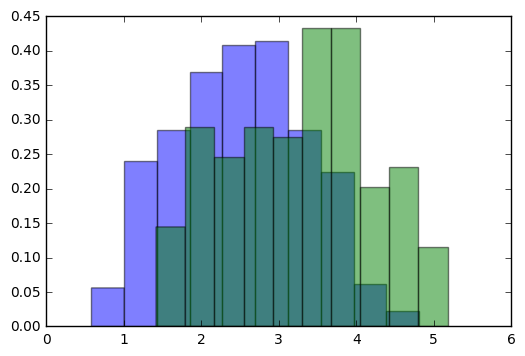

[[294 129]
 [ 72 112]]
Accuracy after regression: 3 --- 0.668863261944
[[330  93]
 [ 84 100]]
Accuracy after regression: 3.25 --- 0.708401976936
[[363  60]
 [102  82]]
Accuracy after regression: 3.5 --- 0.733113673806
[[393  30]
 [122  62]]
Accuracy after regression: 3.75 --- 0.749588138386
[[409  14]
 [142  42]]
Accuracy after regression: 4 --- 0.742998352554
Fold 2 / 5
MAD: 1.21818103078


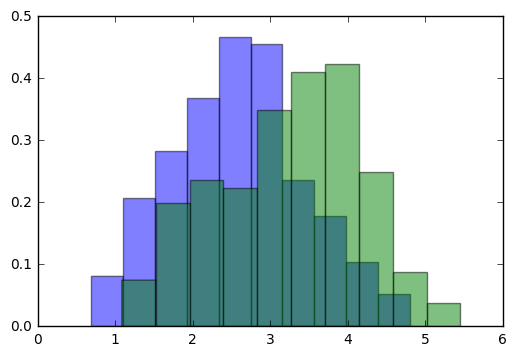

[[295 127]
 [ 66 118]]
Accuracy after regression: 3 --- 0.681518151815
[[333  89]
 [ 87  97]]
Accuracy after regression: 3.25 --- 0.709570957096
[[359  63]
 [107  77]]
Accuracy after regression: 3.5 --- 0.719471947195
[[378  44]
 [120  64]]
Accuracy after regression: 3.75 --- 0.729372937294
[[396  26]
 [143  41]]
Accuracy after regression: 4 --- 0.721122112211
Fold 3 / 5
MAD: 1.18233595879


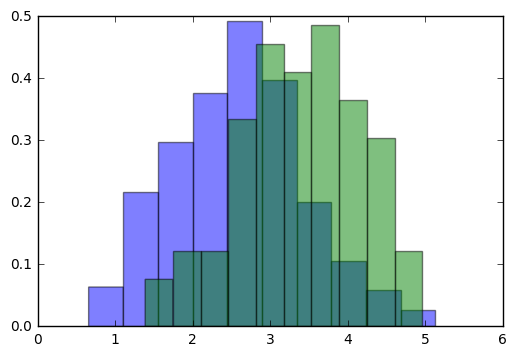

[[295 127]
 [ 62 122]]
Accuracy after regression: 3 --- 0.688118811881
[[335  87]
 [ 78 106]]
Accuracy after regression: 3.25 --- 0.727722772277
[[362  60]
 [ 96  88]]
Accuracy after regression: 3.5 --- 0.742574257426
[[384  38]
 [117  67]]
Accuracy after regression: 3.75 --- 0.744224422442
[[394  28]
 [140  44]]
Accuracy after regression: 4 --- 0.722772277228
Fold 4 / 5
MAD: 1.21760300822


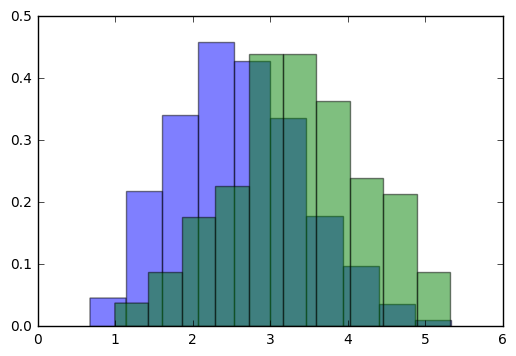

[[293 129]
 [ 65 119]]
Accuracy after regression: 3 --- 0.679867986799
[[335  87]
 [ 83 101]]
Accuracy after regression: 3.25 --- 0.719471947195
[[363  59]
 [103  81]]
Accuracy after regression: 3.5 --- 0.732673267327
[[385  37]
 [120  64]]
Accuracy after regression: 3.75 --- 0.740924092409
[[397  25]
 [140  44]]
Accuracy after regression: 4 --- 0.727722772277
Fold 5 / 5
MAD: 1.23213921043


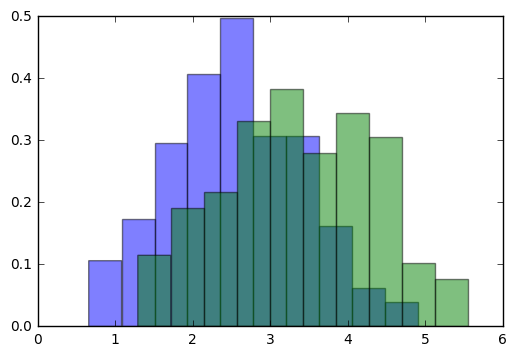

[[292 130]
 [ 67 117]]
Accuracy after regression: 3 --- 0.674917491749
[[327  95]
 [ 85  99]]
Accuracy after regression: 3.25 --- 0.70297029703
[[362  60]
 [106  78]]
Accuracy after regression: 3.5 --- 0.726072607261
[[386  36]
 [113  71]]
Accuracy after regression: 3.75 --- 0.754125412541
[[403  19]
 [126  58]]
Accuracy after regression: 4 --- 0.760726072607
Average CLF accuracy 0.735068317375


In [105]:
# We want to predict if the train will be full when the user gets on
logs_df = pd.read_csv('logs.csv')
#logs_df = logs_df.sample(frac=0.75)


#features_df = logs_df[['dep_sec_since_midnight', 'weekday', 'vehicle_type', 'evening_jam', 'morning_jam']]

features_df = logs_df[['dep_sec_since_midnight', 'weekday', 'vehicle_type', 'month',
                       'from_lat', 'from_lng', 'to_lat', 'to_lng', 'evening_jam', 'morning_jam',
                       'delay_60', 'holiday_type', 'temperature_to', 'temperature_from',
                       'from_drukte', 'to_drukte', 'absolute_freq', 'weighted_freq', 'am_weighted_freq',
                       'line_cat', 'line', 'humidity_to', 'humidity_from', 'weather_type_to', 'weather_type_from',
                       'drukte_absolute_freq', 'drukte_weighted_freq', 'drukte_am_weighted_freq',
                       'delay_15', 'delay_30', 'delay_100']]



features_df.to_csv('simple_features.csv')
features_df = pd.get_dummies(features_df, columns=['weekday', 'line_cat', 'vehicle_type', 
                                                   'line', 'weather_type_to', 'weather_type_from'], drop_first=True)
#features_df = pd.get_dummies(features_df, columns=['weekday', 'vehicle_type'])
print('Features dataframe dimensions:', len(features_df), 'x', len(features_df.columns))
occupancy_mapping = {'low': 0, 'medium': 0, 'high': 1}
labels_clf_df = logs_df['clf_occupancy'].map(occupancy_mapping)
labels_reg_df = logs_df['reg_occupancy']

print(Counter(logs_df['reg_occupancy']))

xgb = XGBClassifier(learning_rate=0.025, n_estimators=750,
                     gamma=0.85, subsample=0.8, colsample_bytree=0.6,
                     nthread=1, scale_pos_weight=1, reg_lambda=0.005,
                     min_child_weight=6, max_depth=11)

xgb_reg = XGBRegressor(learning_rate=0.025, n_estimators=750,
                         gamma=0.85, subsample=0.8, colsample_bytree=0.6,
                         nthread=1, scale_pos_weight=1, reg_lambda=0.005,
                         min_child_weight=6, max_depth=11)

NR_FOLDS = 5
NR_FEATURES = 40

skf = StratifiedKFold(labels_clf_df.values, n_folds=NR_FOLDS, shuffle=True, random_state=1337)

clf_accuracies = []
stacking_features = []
for fold, (train_idx, test_idx) in enumerate(skf):
    print ('Fold', fold+1, '/', NR_FOLDS)
    X_train = features_df.iloc[train_idx, :].reset_index(drop=True)
    y_clf_train = labels_clf_df.iloc[train_idx].reset_index(drop=True)    
    y_reg_train = labels_reg_df.iloc[train_idx].reset_index(drop=True)
    X_test = features_df.iloc[test_idx, :].reset_index(drop=True)
    #weights = y_clf_train.map(lambda x: 1 + 0.5*x)
    y_clf_test = labels_clf_df.iloc[test_idx].reset_index(drop=True)
    y_reg_test = labels_reg_df.iloc[test_idx].reset_index(drop=True)
    
    #svm_args={'class_weight': 'balanced'}
    #svmsmote = SMOTE(ratio='auto', kind='svm', **svm_args)
    #X_train_sampled, y_train_sampled = svmsmote.fit_sample(X_train, y_clf_train)
    #X_train_sampled = pd.DataFrame(X_train_sampled, columns=X_train.columns)
    #f = X_train_sampled.apply(lambda x2: X_train.apply(lambda x1: x1.isin(x2).all(), axis=1).any(), axis=1)
    #print(X_train_sampled[~f])
    #y_train_sampled = pd.DataFrame(y_train_sampled, columns=[y_clf_train.name])[y_clf_train.name]
    #y_reg_train = np.vstack([*y_reg_train.values, *[5.0]*(len(X_train_sampled) - len(X_train))])
    #train_sampled = X_train_sampled.copy()
    #train_sampled[y_train_sampled.name] = y_train_sampled
    
    #xgb = construct_classifier(train_sampled, X_train_sampled.columns, y_train_sampled.name)
    
    #xgb.fit(X_train_sampled, y_train_sampled)
    #selected_features_idx = xgb.feature_importances_.argsort()[-NR_FEATURES:][::-1]
    #plt.bar(range(len(selected_features_idx)), [xgb.feature_importances_[i] for i in selected_features_idx])
    #plt.xticks(range(len(selected_features_idx)), [features_df.columns[i] for i in selected_features_idx], rotation='vertical')
    #plt.show()
    
    #predictions = xgb.predict(X_test)
    #conf_matrix = confusion_matrix(y_clf_test, predictions)
    #print(conf_matrix)
    #acc = sum([conf_matrix[i][i] for i in range(len(conf_matrix))])/np.sum(conf_matrix)
    #print('accuracy:', acc)
    #clf_accuracies.append(acc)
    
    xgb_reg.fit(X_train, y_reg_train)
    #selected_features_idx = xgb_reg.feature_importances_.argsort()[-NR_FEATURES:][::-1]
    #plt.bar(range(len(selected_features_idx)), [xgb_reg.feature_importances_[i] for i in selected_features_idx])
    #plt.xticks(range(len(selected_features_idx)), [features_df.columns[i] for i in selected_features_idx], rotation='vertical')
    #plt.show()

    predictions = xgb_reg.predict(X_test)
    for i in range(len(X_test)):
        entry = X_test.iloc[i,:]
        stacking_features.append(list(entry.values) + [predictions[i], y_clf_test.iloc[i]])
        
    print('MAD:', mean_absolute_error(y_reg_test, predictions))
    pl.hist(list(itertools.compress(predictions, y_clf_test.values==0)),normed=True, alpha=0.5)
    pl.hist(list(itertools.compress(predictions, y_clf_test.values==1)),normed=True, alpha=0.5) 
    #pl.hist(list(itertools.compress(predictions, y_clf_test.values==2)),normed=True, alpha=0.5) 
    pl.show()  
    #thresholds = [3, 3.25, 3.5, 3.75, 4]
    #max_value = 0
    for threshold in thresholds:
        clf_predictions = []
        for prediction in predictions:
            #if 2.5 < float(prediction) < 3.25:
            #    clf_predictions.append(1)
            if float(prediction) <= threshold:
                clf_predictions.append(0)
            else:
                clf_predictions.append(1)
        conf_matrix = confusion_matrix(y_clf_test, clf_predictions)
        print(conf_matrix)
        acc = sum([conf_matrix[i][i] for i in range(len(conf_matrix))])/np.sum(conf_matrix)
        print('Accuracy after regression:', threshold, '---', acc)
        if acc > max_value:
            max_value = acc
    clf_accuracies.append(max_value)
print('Average CLF accuracy', np.mean(clf_accuracies))

stacking_features_df = pd.DataFrame(stacking_features)
stacking_features_df.columns = list(features_df.columns) + ['reg_score', 'label']
stacking_features_df.to_csv('stacking_features.csv')

Features dataframe dimensions: 3031 x 1270
Counter({1.0: 1192, 3.0: 892, 5.0: 884, 4.0: 23, 2.0: 22, 4.333333333333333: 6, 3.6666666666666665: 5, 1.6666666666666667: 2, 3.5: 1, 2.333333333333333: 1, 2.5: 1, 2.6000000000000001: 1, 4.666666666666667: 1})
Fold 1 / 5
Epoch 1/50
2424/2424 [==============================] - 4s - loss: 1.4955     
Epoch 2/50
2424/2424 [==============================] - 4s - loss: 1.3900     
Epoch 3/50
2424/2424 [==============================] - 4s - loss: 1.3572     
Epoch 4/50
2424/2424 [==============================] - 4s - loss: 1.3462     
Epoch 5/50
2424/2424 [==============================] - 4s - loss: 1.3162     
Epoch 6/50
2424/2424 [==============================] - 4s - loss: 1.2798     
Epoch 7/50
2424/2424 [==============================] - 4s - loss: 1.2661     
Epoch 8/50
2424/2424 [==============================] - 4s - loss: 1.2679     
Epoch 9/50
2424/2424 [==============================] - 4s - loss: 1.2433     
Epoch 10/50
2424/2424 [==

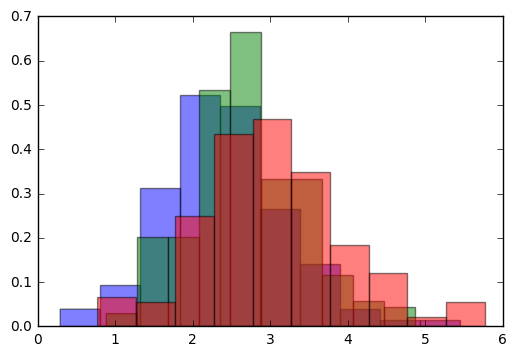

Fold 2 / 5
Epoch 1/50
2424/2424 [==============================] - 4s - loss: 1.4786     
Epoch 2/50
2424/2424 [==============================] - 4s - loss: 1.4079     
Epoch 3/50
2424/2424 [==============================] - 4s - loss: 1.3816     
Epoch 4/50
2424/2424 [==============================] - 4s - loss: 1.3403     
Epoch 5/50
2424/2424 [==============================] - 4s - loss: 1.3093     
Epoch 6/50
2424/2424 [==============================] - 4s - loss: 1.2969     
Epoch 7/50
2424/2424 [==============================] - 5s - loss: 1.2862     
Epoch 8/50
2424/2424 [==============================] - 4s - loss: 1.2628     
Epoch 9/50
2424/2424 [==============================] - 5s - loss: 1.2464     
Epoch 10/50
2424/2424 [==============================] - 4s - loss: 1.2517     
Epoch 11/50
2424/2424 [==============================] - 4s - loss: 1.2175     
Epoch 12/50
2424/2424 [==============================] - 4s - loss: 1.1860     
Epoch 13/50
2424/2424 [===============

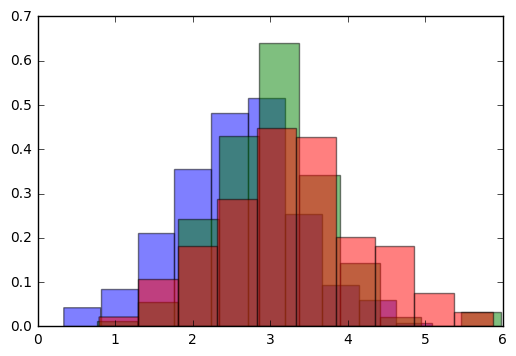

Fold 3 / 5
Epoch 1/50
2425/2425 [==============================] - 4s - loss: 1.4827     
Epoch 2/50
2425/2425 [==============================] - 4s - loss: 1.4050     
Epoch 3/50
2425/2425 [==============================] - 4s - loss: 1.3661     
Epoch 4/50
2425/2425 [==============================] - 4s - loss: 1.3336     
Epoch 5/50
2425/2425 [==============================] - 6s - loss: 1.3127     
Epoch 6/50
2425/2425 [==============================] - 6s - loss: 1.2988     
Epoch 7/50
2425/2425 [==============================] - 6s - loss: 1.2700     
Epoch 8/50
2425/2425 [==============================] - 6s - loss: 1.2907     
Epoch 9/50
2425/2425 [==============================] - 6s - loss: 1.2583     
Epoch 10/50
2425/2425 [==============================] - 6s - loss: 1.2483     
Epoch 11/50
2425/2425 [==============================] - 7s - loss: 1.2240     
Epoch 12/50
2425/2425 [==============================] - 7s - loss: 1.2240     
Epoch 13/50
2425/2425 [===============

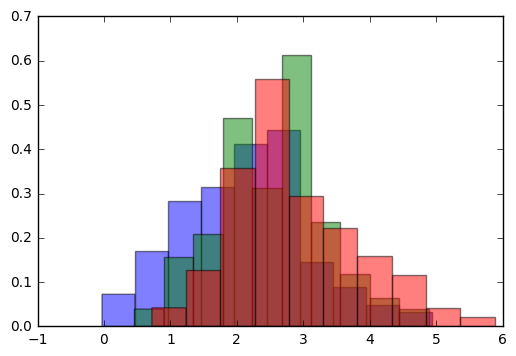

Fold 4 / 5
Epoch 1/50
2425/2425 [==============================] - 4s - loss: 1.4894     
Epoch 2/50
2425/2425 [==============================] - 4s - loss: 1.4122     
Epoch 3/50
2425/2425 [==============================] - 6s - loss: 1.3742     
Epoch 4/50
2425/2425 [==============================] - 6s - loss: 1.3448     
Epoch 5/50
2425/2425 [==============================] - 6s - loss: 1.3091     
Epoch 6/50
2425/2425 [==============================] - 6s - loss: 1.3243     
Epoch 7/50
2425/2425 [==============================] - 6s - loss: 1.2861     
Epoch 8/50
2425/2425 [==============================] - 6s - loss: 1.2613     
Epoch 9/50
2425/2425 [==============================] - 5s - loss: 1.2560     
Epoch 10/50
2425/2425 [==============================] - 6s - loss: 1.2582     
Epoch 11/50
2425/2425 [==============================] - 7s - loss: 1.2474     
Epoch 12/50
2425/2425 [==============================] - 7s - loss: 1.2293     
Epoch 13/50
2425/2425 [===============

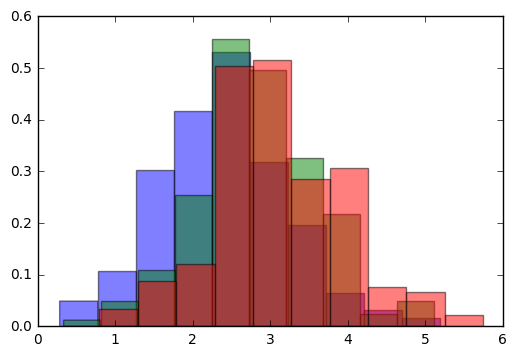

Fold 5 / 5
Epoch 1/50
2426/2426 [==============================] - 6s - loss: 1.4831     
Epoch 2/50
2426/2426 [==============================] - 5s - loss: 1.3949     
Epoch 3/50
2426/2426 [==============================] - 4s - loss: 1.3839     
Epoch 4/50
2426/2426 [==============================] - 4s - loss: 1.3506     
Epoch 5/50
2426/2426 [==============================] - 7s - loss: 1.3290     
Epoch 6/50
2426/2426 [==============================] - 6s - loss: 1.3174     
Epoch 7/50
2426/2426 [==============================] - 6s - loss: 1.2917     
Epoch 8/50
2426/2426 [==============================] - 6s - loss: 1.2890     
Epoch 9/50
2426/2426 [==============================] - 6s - loss: 1.2549     
Epoch 10/50
2426/2426 [==============================] - 5s - loss: 1.2772     
Epoch 11/50
2426/2426 [==============================] - 5s - loss: 1.2483     
Epoch 12/50
2426/2426 [==============================] - 5s - loss: 1.2387     
Epoch 13/50
2426/2426 [===============

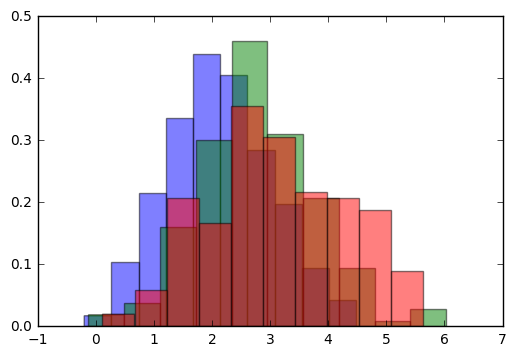

In [30]:
logs_df = pd.read_csv('logs.csv')

features_df = logs_df[['dep_sec_since_midnight', 'weekday', 'vehicle_type', 'month',
                       'from_lat', 'from_lng', 'to_lat', 'to_lng', 'evening_jam', 'morning_jam',
                       'delay_60', 'holiday_type', 'temperature_to', 'temperature_from',
                       'from_drukte', 'to_drukte', 'absolute_freq', 'weighted_freq', 'am_weighted_freq',
                       'line_cat', 'line', 'humidity_to', 'humidity_from', 'weather_type_to', 'weather_type_from',
                       'drukte_absolute_freq', 'drukte_weighted_freq', 'drukte_am_weighted_freq',
                       'delay_15', 'delay_30', 'delay_100']]

x = features_df[['dep_sec_since_midnight', 'month',
           'from_lat', 'from_lng', 'to_lat', 'to_lng', 'evening_jam', 'morning_jam',
           'delay_60', 'holiday_type', 'temperature_to', 'temperature_from',
           'from_drukte', 'to_drukte', 'absolute_freq', 'weighted_freq', 'am_weighted_freq',
           'humidity_to', 'humidity_from',
           'drukte_absolute_freq', 'drukte_weighted_freq', 'drukte_am_weighted_freq',
           'delay_15', 'delay_30', 'delay_100']].values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
features_df[['dep_sec_since_midnight', 'month',
           'from_lat', 'from_lng', 'to_lat', 'to_lng', 'evening_jam', 'morning_jam',
           'delay_60', 'holiday_type', 'temperature_to', 'temperature_from',
           'from_drukte', 'to_drukte', 'absolute_freq', 'weighted_freq', 'am_weighted_freq',
           'humidity_to', 'humidity_from', 
           'drukte_absolute_freq', 'drukte_weighted_freq', 'drukte_am_weighted_freq',
           'delay_15', 'delay_30', 'delay_100']] = pd.DataFrame(x_scaled)
features_df = pd.get_dummies(features_df, columns=['weekday', 'line_cat', 'vehicle_type', 
                                                   'line', 'weather_type_to', 'weather_type_from'], drop_first=True)
print('Features dataframe dimensions:', len(features_df), 'x', len(features_df.columns))

occupancy_mapping = {'low': 0, 'medium': 1, 'high': 2}
labels_clf_df = logs_df['clf_occupancy'].map(occupancy_mapping)
labels_reg_df = logs_df['reg_occupancy']
#labels_reg_df = (labels_reg_df - labels_reg_df.mean()) / (labels_reg_df.max() - labels_reg_df.min())

print(Counter(logs_df['reg_occupancy']))

def baseline_model():
    model = Sequential()
    model.add(Dense(750, input_dim=1270, init='uniform', activation='relu', W_constraint=maxnorm(5)))
    model.add(Dropout(0.33))
    #model.add(Dense(250, init='uniform', activation='relu', W_constraint=maxnorm(5)))
    #model.add(Dropout(0.1))
    #model.add(Dense(100, init='uniform', activation='relu', W_constraint=maxnorm(5)))
    model.add(Dense(1, init='uniform'))
    sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='mean_absolute_error', optimizer=sgd)
    return model

estimator = KerasRegressor(build_fn=baseline_model, nb_epoch=50, batch_size=32, verbose=1)

xgb_reg = XGBRegressor(learning_rate=0.025, n_estimators=750,
                         gamma=0.85, subsample=0.8, colsample_bytree=0.6,
                         nthread=1, scale_pos_weight=1, reg_lambda=0.005,
                         min_child_weight=6, max_depth=11)

NR_FOLDS = 5
NR_FEATURES = 40

skf = StratifiedKFold(labels_clf_df.values, n_folds=NR_FOLDS, shuffle=True, random_state=1337)

clf_accuracies = []
stacking_features = []
for fold, (train_idx, test_idx) in enumerate(skf):
    print ('Fold', fold+1, '/', NR_FOLDS)
    X_train = features_df.iloc[train_idx, :].reset_index(drop=True)
    y_clf_train = labels_clf_df.iloc[train_idx].reset_index(drop=True)    
    y_reg_train = labels_reg_df.iloc[train_idx].reset_index(drop=True)
    X_test = features_df.iloc[test_idx, :].reset_index(drop=True)
    y_clf_test = labels_clf_df.iloc[test_idx].reset_index(drop=True)
    y_reg_test = labels_reg_df.iloc[test_idx].reset_index(drop=True)
    
    estimator.fit(X_train.as_matrix(), y_reg_train.as_matrix())
    predictions = estimator.predict(X_test.as_matrix())
    
    xgb_reg.fit(X_train, y_reg_train)
    xgb_predictions = xgb_reg.predict(X_test)
    
    for i in range(len(X_test)):
        entry = X_test.iloc[i,:]
        stacking_features.append(list(entry.values) + [predictions[i], xgb_predictions[i], y_clf_test.iloc[i]])
        
    print('\n --> MAD NN:', mean_absolute_error(y_reg_test, predictions))
    print('\n --> MAD XGB:', mean_absolute_error(y_reg_test, xgb_predictions))
    print('\n --> corr:', np.corrcoef(predictions, xgb_predictions))
    pl.hist(list(itertools.compress(predictions, y_clf_test.values==0)),normed=True, alpha=0.5)
    pl.hist(list(itertools.compress(predictions, y_clf_test.values==1)),normed=True, alpha=0.5) 
    pl.hist(list(itertools.compress(predictions, y_clf_test.values==2)),normed=True, alpha=0.5) 
    pl.show()  
    #thresholds = [3, 3.25, 3.5, 3.75, 4]
    #max_value = 0
    #for threshold in thresholds:
    #    clf_predictions = []
    #    for prediction in predictions:
    #        #if 2.5 < float(prediction) < 3.25:
    #        #    clf_predictions.append(1)
    #        if float(prediction) <= threshold:
    #            clf_predictions.append(0)
    #        else:
    #            clf_predictions.append(1)
    #    conf_matrix = confusion_matrix(y_clf_test, clf_predictions)
    #    print(conf_matrix)
    #    acc = sum([conf_matrix[i][i] for i in range(len(conf_matrix))])/np.sum(conf_matrix)
    #    print('Accuracy after regression:', threshold, '---', acc)
    #    if acc > max_value:
    #        max_value = acc
    #clf_accuracies.append(max_value)
#print('Average CLF accuracy', np.mean(clf_accuracies))

stacking_features_df = pd.DataFrame(stacking_features)
stacking_features_df.columns = list(features_df.columns) + ['reg_score_nn', 'reg_score_xgb', 'label']
stacking_features_df.to_csv('stacking_features.csv')

Fold 1 / 5


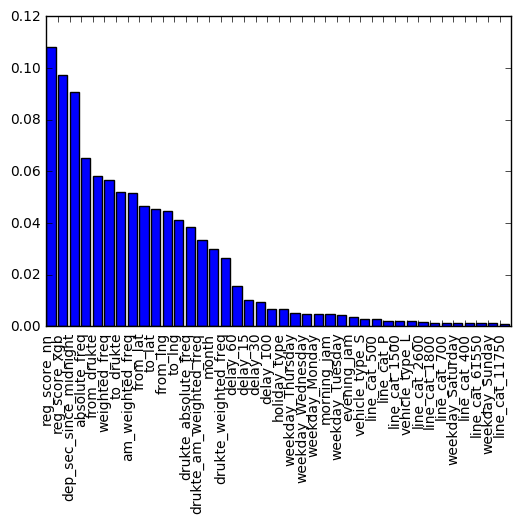

[[166  56  27]
 [ 68  67  39]
 [ 40  60  84]]
accuracy: 0.522240527183
Fold 2 / 5


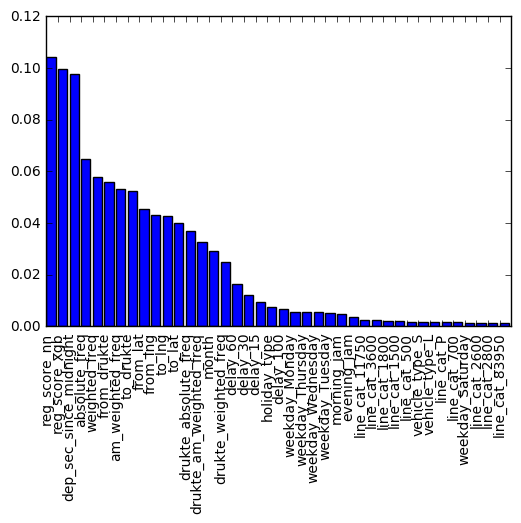

[[165  52  32]
 [ 51  81  42]
 [ 41  52  91]]
accuracy: 0.555189456343
Fold 3 / 5


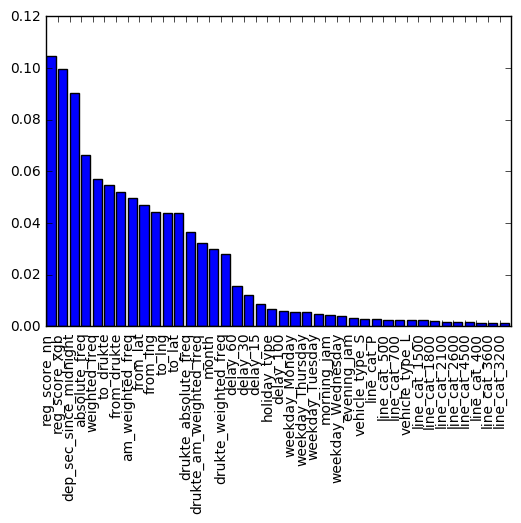

[[169  54  26]
 [ 60  73  40]
 [ 42  57  85]]
accuracy: 0.539603960396
Fold 4 / 5


KeyboardInterrupt: 

In [24]:
# We want to predict if the train will be full when the user gets on
features_df = pd.read_csv('stacking_features.csv')
labels_df = features_df['label']
#labels_df = labels_df.apply(lambda x: {0: 0, 1: 0, 2: 1}[x])
features_df = features_df.drop(['label', 'Unnamed: 0'], axis=1)
#features_df = features_df[['reg_score_nn', 'reg_score_xgb']]

xgb = XGBClassifier(learning_rate=0.025, n_estimators=750,
                     gamma=0.85, subsample=0.8, colsample_bytree=0.6,
                     nthread=1, scale_pos_weight=1, reg_lambda=0.005,
                     min_child_weight=6, max_depth=11)

NR_FOLDS = 5
NR_FEATURES = 40

skf = StratifiedKFold(labels_df.values, n_folds=NR_FOLDS, shuffle=True, random_state=1337)

clf_accuracies = []
for fold, (train_idx, test_idx) in enumerate(skf):
    print ('Fold', fold+1, '/', NR_FOLDS)
    X_train = features_df.iloc[train_idx, :].reset_index(drop=True)
    y_clf_train = labels_df.iloc[train_idx].reset_index(drop=True)  
    X_test = features_df.iloc[test_idx, :].reset_index(drop=True)
    y_clf_test = labels_df.iloc[test_idx].reset_index(drop=True)
    
    svm_args={'class_weight': 'balanced'}
    svmsmote = SMOTE(ratio='auto', kind='svm', **svm_args)
    X_train_sampled, y_train_sampled = svmsmote.fit_sample(X_train, y_clf_train)
    X_train_sampled = pd.DataFrame(X_train_sampled, columns=X_train.columns)
    y_train_sampled = pd.DataFrame(y_train_sampled, columns=[y_clf_train.name])[y_clf_train.name]
    
    xgb.fit(X_train_sampled, y_train_sampled)
    selected_features_idx = xgb.feature_importances_.argsort()[-NR_FEATURES:][::-1]
    plt.bar(range(len(selected_features_idx)), [xgb.feature_importances_[i] for i in selected_features_idx])
    plt.xticks(range(len(selected_features_idx)), [features_df.columns[i] for i in selected_features_idx], rotation='vertical')
    plt.show()
    
    predictions = xgb.predict(X_test)
    conf_matrix = confusion_matrix(y_clf_test, predictions)
    print(conf_matrix)
    acc = sum([conf_matrix[i][i] for i in range(len(conf_matrix))])/np.sum(conf_matrix)
    print('accuracy:', acc)
    clf_accuracies.append(acc)
print('Average CLF accuracy', np.mean(clf_accuracies))

Features dataframe dimensions: 1900 x 26
Fold 1 / 5


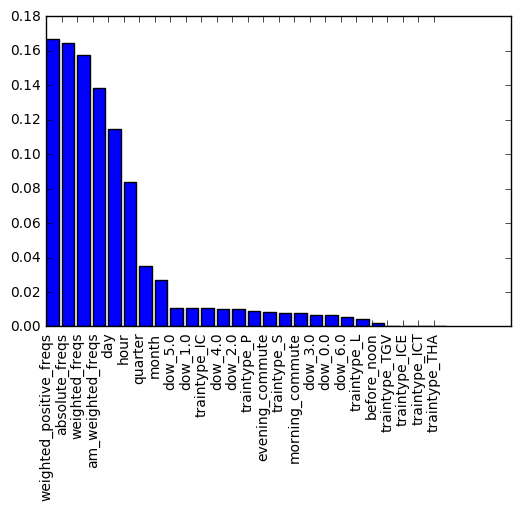

[[85 38 29]
 [31 48 33]
 [27 36 54]]
accuracy: 0.490813648294
Fold 2 / 5


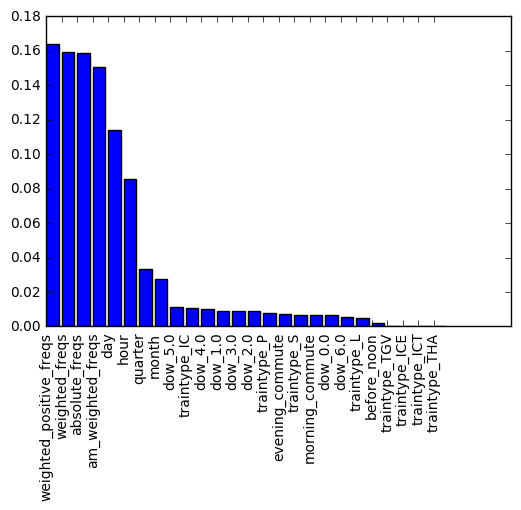

[[95 26 31]
 [46 38 28]
 [36 31 50]]
accuracy: 0.48031496063
Fold 3 / 5


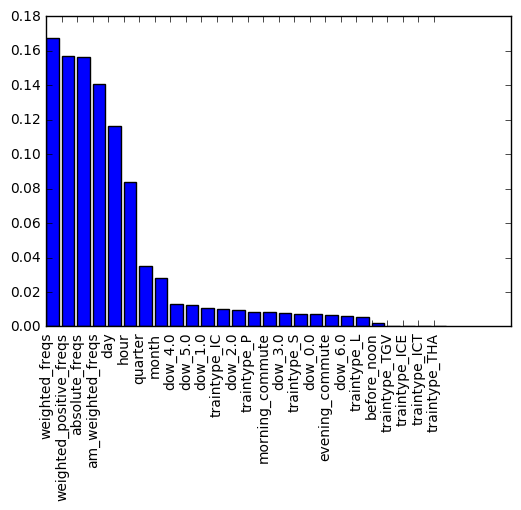

[[97 29 25]
 [43 37 32]
 [37 35 45]]
accuracy: 0.471052631579
Fold 4 / 5


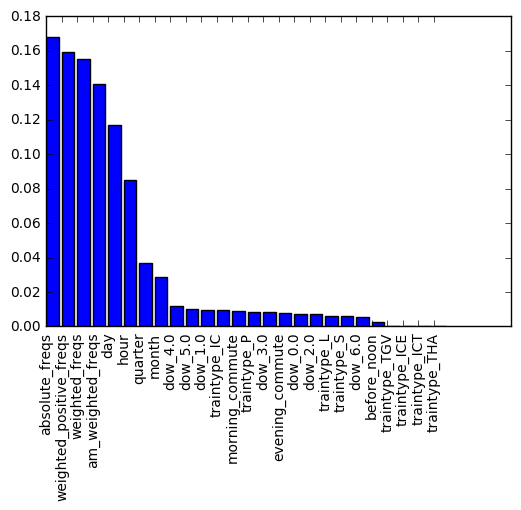

[[98 27 26]
 [31 40 40]
 [35 25 57]]
accuracy: 0.514511873351
Fold 5 / 5


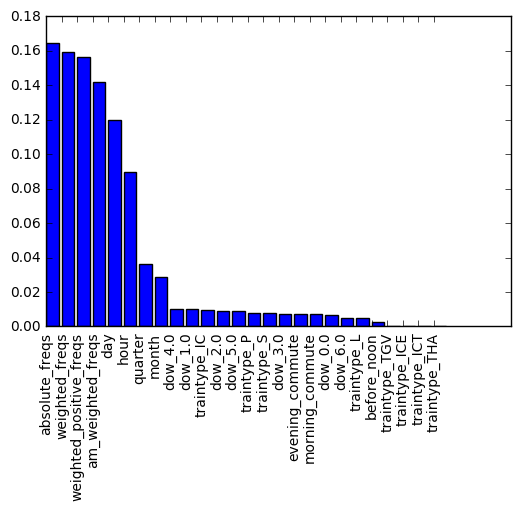

[[86 34 31]
 [34 41 36]
 [29 34 54]]
accuracy: 0.477572559367
Average CLF accuracy 0.486853134644


In [141]:
# We want to predict if the train will be full when the user gets on
logs_df = pd.read_csv('features.csv')
#logs_df = logs_df.sample(frac=0.75)

logs_df = logs_df.drop_duplicates()

features_df = logs_df[['month',
                        'day',
                        'dow',
                        'hour',
                        'quarter',
                        #'vehicle',
                        # 'stationfrom', #departurestop
                        # 'arrivalstop',
                        'traintype',
                        #'departurename',
                        #'arrivalname',
                        'weighted_freqs',
                        'absolute_freqs',
                        #'distance',
                        'weighted_positive_freqs',
                        'am_weighted_freqs',
                        'before_noon',
                        'morning_commute',
                        'evening_commute']]

# discarded features: 'drukte_absolute_freq', 'drukte_weighted_freq', 'drukte_am_weighted_freq',
# 'delay_15', 'delay_30', 'delay_100', , 'windspeed_to', 'visibility_to', 'weather_type_to'
# 'windspeed_from', 'visibility_from', 'weather_type_from', 'temperature_to', 'temperature_from'

features_df = pd.get_dummies(features_df, columns=['dow', 'traintype'])
print('Features dataframe dimensions:', len(features_df), 'x', len(features_df.columns))
occupancy_mapping = {'low': 0, 'medium': 1, 'high': 2}
labels_clf_df = logs_df['occupancy'].map(occupancy_mapping)

xgb = XGBClassifier(learning_rate=0.075, n_estimators=1750,
                     gamma=0.9, subsample=0.75, colsample_bytree=0.7,
                     nthread=1, scale_pos_weight=1, reg_lambda=0.25,
                     min_child_weight=5, max_depth=13)

NR_FOLDS = 5
NR_FEATURES = 40

skf = StratifiedKFold(labels_clf_df.values, n_folds=NR_FOLDS, shuffle=True, random_state=1337)

clf_accuracies = []
for fold, (train_idx, test_idx) in enumerate(skf):
    print ('Fold', fold+1, '/', NR_FOLDS)
    X_train = features_df.iloc[train_idx, :].reset_index(drop=True)
    y_clf_train = labels_clf_df.iloc[train_idx].reset_index(drop=True)    
    X_test = features_df.iloc[test_idx, :].reset_index(drop=True)
    y_clf_test = labels_clf_df.iloc[test_idx].reset_index(drop=True)
    
    xgb.fit(X_train, y_clf_train)
    selected_features_idx = xgb.feature_importances_.argsort()[-NR_FEATURES:][::-1]
    plt.bar(range(len(selected_features_idx)), [xgb.feature_importances_[i] for i in selected_features_idx])
    plt.xticks(range(len(selected_features_idx)), [features_df.columns[i] for i in selected_features_idx], rotation='vertical')
    plt.show()
    
    predictions = xgb.predict(X_test)
    conf_matrix = confusion_matrix(y_clf_test, predictions)
    print(conf_matrix)
    acc = sum([conf_matrix[i][i] for i in range(len(conf_matrix))])/np.sum(conf_matrix)
    print('accuracy:', acc)
    clf_accuracies.append(acc)

print('Average CLF accuracy', np.mean(clf_accuracies))

In [3]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

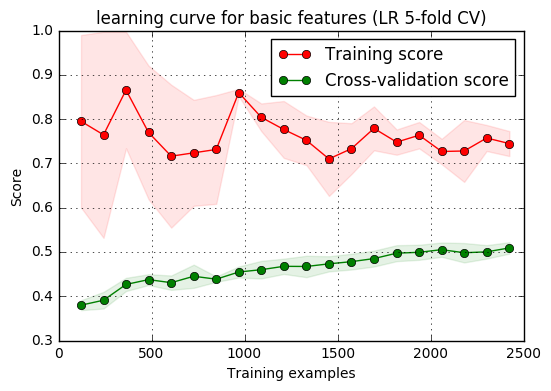

In [9]:
logs_df = pd.read_csv('logs.csv')

features_df = logs_df[['dep_sec_since_midnight', 'weekday', 'vehicle_type', 'month',
                       'from_lat', 'from_lng', 'to_lat', 'to_lng', 'evening_jam', 'morning_jam',
                       'delay_60', 'holiday_type', 'temperature_to', 'temperature_from',
                       'from_drukte', 'to_drukte', 'absolute_freq', 'weighted_freq', 'am_weighted_freq',
                       'line_cat', 'line', 'humidity_to', 'humidity_from', 'weather_type_to', 'weather_type_from',
                       'drukte_absolute_freq', 'drukte_weighted_freq', 'drukte_am_weighted_freq',
                       'delay_15', 'delay_30', 'delay_100']]
features_df = pd.get_dummies(features_df, columns=['weekday', 'line_cat', 'vehicle_type', 
                                                   'line', 'weather_type_to', 'weather_type_from'], drop_first=True)
labels_df = logs_df['clf_occupancy']

train_sizes = np.linspace(0.05,1.0,num=20)
skf = StratifiedKFold(labels_df.values, n_folds=5, shuffle=True, random_state=1337)
params = {'C':[1,5,10,0.1,0.01], 'solver': ['newton-cg', 'lbfgs', 'liblinear']}
lr = LogisticRegression(tol=1e-9)
clf = GridSearchCV(lr ,params, refit='True', n_jobs=1, cv=3, verbose=0)
plot_learning_curve(clf, 'learning curve for basic features (LR 5-fold CV)', features_df, labels_df, train_sizes=train_sizes, cv=skf)
plt.show()